#TP3

Base de dados de uma empresa de Telecom que oferta diversos serviços, entre os principais: internet e telefone.

Ao analisar o histórico dos clientes dos últimos anos percebe-se que a empresa está com Churn (taxa de cancelamento) de mais de 26% dos clientes. O trabalho consiste em encontrar uma (ou mais regras) que seja o mais acurada possível para determinar os clientes com churn (os clientes que cancelaram). Deve-se utilizar algoritmos genéticos ou programação genética para encontrar tal regra.

Link no Kaggle: https://www.kaggle.com/radmirzosimov/telecom-users-dataset

In [327]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [303]:
df = pd.read_csv('telecom_users.csv')
df

,Unnamed: 0,IDCliente,Genero,Aposentado,Casado,Dependentes,MesesComoCliente,ServicoTelefone,MultiplasLinhas,ServicoInternet,...,ServicoSuporteTecnico,ServicoStreamingTV,ServicoFilmes,TipoContrato,FaturaDigital,FormaPagamento,ValorMensal,TotalGasto,Churn,Codigo
0,1869,7010-BRBUU,Masculino,0,Sim,Sim,72,Sim,Sim,Nao,...,SemInternet,SemInternet,SemInternet,2 anos,Nao,CartaoCredito,24.10,1734.65,Nao,NaN
1,4528,9688-YGXVR,Feminino,0,Nao,Nao,44,Sim,Nao,Fibra,...,Nao,Sim,Nao,Mensal,Sim,CartaoCredito,88.15,3973.2,Nao,NaN
2,6344,9286-DOJGF,Feminino,1,Sim,Nao,38,Sim,Sim,Fibra,...,Nao,Nao,Nao,Mensal,Sim,DebitoAutomatico,74.95,2869.85,Sim,NaN
3,6739,6994-KERXL,Masculino,0,Nao,Nao,4,Sim,Nao,DSL,...,Nao,Nao,Sim,Mensal,Sim,BoletoEletronico,55.90,238.5,Nao,NaN
4,432,2181-UAESM,Masculino,0,Nao,Nao,2,Sim,Nao,DSL,...,Nao,Nao,Nao,Mensal,Nao,BoletoEletronico,53.45,119.5,Nao,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,3772,0684-AOSIH,Masculino,0,Sim,Nao,1,Sim,Nao,Fibra,...,Nao,Sim,Sim,Mensal,Sim,BoletoEletronico,95.00,95,Sim,NaN
5982,5191,5982-PSMKW,Feminino,0,Sim,Sim,23,Sim,Sim,DSL,...,Sim,Sim,Sim,2 anos,Sim,CartaoCredito,91.10,2198.3,Nao,NaN
5983,5226,8044-BGWPI,Masculino,0,Sim,Sim,12,Sim,Nao,Nao,...,SemInternet,SemInternet,SemInternet,Mensal,Sim,BoletoEletronico,21.15,306.05,Nao,NaN
5984,5390,7450-NWRTR,Masculino,1,Nao,Nao,12,Sim,Sim,Fibra,...,Nao,Sim,Sim,Mensal,Sim,BoletoEletronico,99.45,1200.15,Sim,NaN


In [304]:
# Passo 2: Visualizar a base de dados
# Entender quais informações estão disponíveis
# Retirada da primeira coluna
df = df.drop(columns=["Unnamed: 0", "IDCliente"], axis=1) # 0 é linha e 1 é coluna
df

,Genero,Aposentado,Casado,Dependentes,MesesComoCliente,ServicoTelefone,MultiplasLinhas,ServicoInternet,ServicoSegurancaOnline,ServicoBackupOnline,...,ServicoSuporteTecnico,ServicoStreamingTV,ServicoFilmes,TipoContrato,FaturaDigital,FormaPagamento,ValorMensal,TotalGasto,Churn,Codigo
0,Masculino,0,Sim,Sim,72,Sim,Sim,Nao,SemInternet,SemInternet,...,SemInternet,SemInternet,SemInternet,2 anos,Nao,CartaoCredito,24.10,1734.65,Nao,NaN
1,Feminino,0,Nao,Nao,44,Sim,Nao,Fibra,Nao,Sim,...,Nao,Sim,Nao,Mensal,Sim,CartaoCredito,88.15,3973.2,Nao,NaN
2,Feminino,1,Sim,Nao,38,Sim,Sim,Fibra,Nao,Nao,...,Nao,Nao,Nao,Mensal,Sim,DebitoAutomatico,74.95,2869.85,Sim,NaN
3,Masculino,0,Nao,Nao,4,Sim,Nao,DSL,Nao,Nao,...,Nao,Nao,Sim,Mensal,Sim,BoletoEletronico,55.90,238.5,Nao,NaN
4,Masculino,0,Nao,Nao,2,Sim,Nao,DSL,Sim,Nao,...,Nao,Nao,Nao,Mensal,Nao,BoletoEletronico,53.45,119.5,Nao,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,Masculino,0,Sim,Nao,1,Sim,Nao,Fibra,Sim,Nao,...,Nao,Sim,Sim,Mensal,Sim,BoletoEletronico,95.00,95,Sim,NaN
5982,Feminino,0,Sim,Sim,23,Sim,Sim,DSL,Sim,Sim,...,Sim,Sim,Sim,2 anos,Sim,CartaoCredito,91.10,2198.3,Nao,NaN
5983,Masculino,0,Sim,Sim,12,Sim,Nao,Nao,SemInternet,SemInternet,...,SemInternet,SemInternet,SemInternet,Mensal,Sim,BoletoEletronico,21.15,306.05,Nao,NaN
5984,Masculino,1,Nao,Nao,12,Sim,Sim,Fibra,Nao,Nao,...,Nao,Sim,Sim,Mensal,Sim,BoletoEletronico,99.45,1200.15,Sim,NaN


In [305]:
# Passo 3: Tratamento da base de dados
# Valores que são números mas que o Python acha que são texto
df["TotalGasto"] = pd.to_numeric(df["TotalGasto"], errors="coerce")

# Valores que estão vazios
# colunas vazias
# any para excluir colunas que tem PELO MENOS 1 valor vazio
# all para excluir colunas COMPLETAMENTE vazias
df = df.dropna(how="all", axis=1) 

# linhas vazias
df = df.dropna(how="any", axis=0) 

# note que a limpeza excluiu 12 registros
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5974 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Genero                  5974 non-null   object 
 1   Aposentado              5974 non-null   int64  
 2   Casado                  5974 non-null   object 
 3   Dependentes             5974 non-null   object 
 4   MesesComoCliente        5974 non-null   int64  
 5   ServicoTelefone         5974 non-null   object 
 6   MultiplasLinhas         5974 non-null   object 
 7   ServicoInternet         5974 non-null   object 
 8   ServicoSegurancaOnline  5974 non-null   object 
 9   ServicoBackupOnline     5974 non-null   object 
 10  ProtecaoEquipamento     5974 non-null   object 
 11  ServicoSuporteTecnico   5974 non-null   object 
 12  ServicoStreamingTV      5974 non-null   object 
 13  ServicoFilmes           5974 non-null   object 
 14  TipoContrato            5974 non-null   

In [306]:
# Passo 4: Análise Exploratória -> Análise Geral -> Ver como estão os cancelamentos

print(df["Churn"].value_counts())
print(df["Churn"].value_counts(normalize=True).map("{:.1%}".format))

Nao    4387
Sim    1587
Name: Churn, dtype: int64
Nao    73.4%
Sim    26.6%
Name: Churn, dtype: object


In [307]:
categorical = ['Genero','Casado', 'Dependentes', "ServicoTelefone", "MultiplasLinhas", "ServicoInternet", "ServicoSegurancaOnline", "ServicoBackupOnline", "ProtecaoEquipamento", "ServicoSuporteTecnico", "ServicoStreamingTV", "ServicoFilmes", "TipoContrato", "FaturaDigital", "FormaPagamento", "Churn"]
stacked = df[categorical].stack()
df[categorical] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()
df

,Genero,Aposentado,Casado,Dependentes,MesesComoCliente,ServicoTelefone,MultiplasLinhas,ServicoInternet,ServicoSegurancaOnline,ServicoBackupOnline,ProtecaoEquipamento,ServicoSuporteTecnico,ServicoStreamingTV,ServicoFilmes,TipoContrato,FaturaDigital,FormaPagamento,ValorMensal,TotalGasto,Churn
0,0,0,1,1,72,1,1,2,3,3,3,3,3,3,4,2,5,24.10,1734.65,2
1,6,0,2,2,44,1,2,7,2,1,1,2,1,2,8,1,5,88.15,3973.20,2
2,6,1,1,2,38,1,1,7,2,2,2,2,2,2,8,1,9,74.95,2869.85,1
3,0,0,2,2,4,1,2,10,2,2,2,2,2,1,8,1,11,55.90,238.50,2
4,0,0,2,2,2,1,2,10,1,2,1,2,2,2,8,2,11,53.45,119.50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,0,0,1,2,1,1,2,7,1,2,2,2,1,1,8,1,11,95.00,95.00,1
5982,6,0,1,1,23,1,1,10,1,1,1,1,1,1,4,1,5,91.10,2198.30,2
5983,0,0,1,1,12,1,2,2,3,3,3,3,3,3,8,1,11,21.15,306.05,2
5984,0,1,2,2,12,1,1,7,2,2,1,2,1,1,8,1,11,99.45,1200.15,1


In [308]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "Churn"], df["Churn"], test_size=0.30, random_state=1)

In [309]:
#training a logistics regression model
logmodel = LogisticRegression(max_iter=5000)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print("Accuracy = "+ str(accuracy_score(y_test,predictions)))

Accuracy = 0.7836029001673174


In [310]:
#defining various steps required for the genetic algorithm
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],y_train)
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        #print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [315]:
chromo,score=generations(size=200,n_feat=19,n_parents=40,mutation_rate=0.10, n_gen=38)

In [326]:
logmodel.fit(X_train.iloc[:,chromo[-1]], y_train)
predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])

best_config = X_test.iloc[:,chromo[-1]].columns

Index(['Aposentado', 'MesesComoCliente', 'ServicoTelefone',
       'ServicoSegurancaOnline', 'ProtecaoEquipamento', 'ServicoStreamingTV',
       'TipoContrato', 'FaturaDigital', 'FormaPagamento', 'ValorMensal',
       'TotalGasto'],
      dtype='object')

In [312]:
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
cm

array([[ 213,  258],
       [ 132, 1190]])

In [313]:
def accuracy(tp, fn, fp, tn):
  return (tp + tn) / (tp + tn + fp + fn)

acc = accuracy(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

print(f"Acurácia: {acc}")
print(f"Melhor configuração: {best_config}")

Acurácia: 0.7824874511991077


## Primeira configuração

In [333]:
size = 10
n_parents = 5
mutation_rate = 0.10
n_gen = 10

best_config = []
scores = []

for i in range(0, 30):
  chromo,score=generations(size=size,n_feat=19,n_parents=n_parents,mutation_rate=mutation_rate,n_gen=n_gen)
  logmodel.fit(X_train.iloc[:,chromo[-1]], y_train)
  predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])

  config = X_test.iloc[:,chromo[-1]].columns
  cm = confusion_matrix(y_true=y_test, y_pred=predictions)
  acc = accuracy(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

  print(f"Acurácia: {acc}")

  if((len(scores) and acc > max(scores)) or not len(scores)):
    best_config = config

  scores.append(acc)

Acurácia: 0.7802565532626883
Acurácia: 0.7852760736196319
Acurácia: 0.7852760736196319
Acurácia: 0.7875069715560513
Acurácia: 0.77356385945343
Acurácia: 0.7373117679866146
Acurácia: 0.7724484104852203
Acurácia: 0.7819297267150028
Acurácia: 0.7836029001673174
Acurácia: 0.7573898494143892
Acurácia: 0.7757947573898494
Acurácia: 0.7741215839375348
Acurácia: 0.7785833798103736
Acurácia: 0.7752370329057445
Acurácia: 0.7685443390964863
Acurácia: 0.7841606246514222
Acurácia: 0.7757947573898494
Acurácia: 0.7808142777467931
Acurácia: 0.7763524818739542
Acurácia: 0.7819297267150028
Acurácia: 0.7401003904071388
Acurácia: 0.7819297267150028
Acurácia: 0.7423312883435583
Acurácia: 0.7847183491355271
Acurácia: 0.7785833798103736
Acurácia: 0.7791411042944786
Acurácia: 0.7802565532626883
Acurácia: 0.7785833798103736
Acurácia: 0.7808142777467931
Acurácia: 0.7601784718349136


Mínimo: 0.7373117679866146
Máximo: 0.7875069715560513
Média: 0.7740844023052612
Desvio Padrão: 0.013174528470540982
Melhor configuração: Index(['Aposentado', 'Dependentes', 'MesesComoCliente', 'MultiplasLinhas',
       'ServicoInternet', 'ServicoSegurancaOnline', 'ProtecaoEquipamento',
       'ServicoStreamingTV', 'ServicoFilmes', 'TipoContrato', 'FaturaDigital',
       'FormaPagamento', 'ValorMensal'],
      dtype='object')


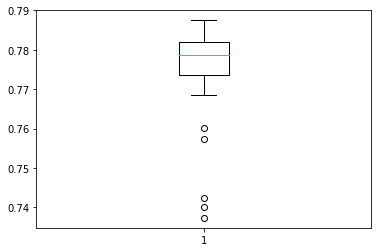

In [334]:
print(f"Mínimo: {min(scores)}")
print(f"Máximo: {max(scores)}")
print(f"Média: {np.mean(scores)}")
print(f"Desvio Padrão: {np.std(scores)}")

print(f"Melhor configuração: {best_config}")

plt.boxplot(scores)
plt.show()

## Segunda configuração

In [ ]:
size = 10
n_parents = 5
mutation_rate = 0.10
n_gen = 10

best_config = []
scores = []

for i in range(0, 30):
  chromo,score=generations(size=size,n_feat=19,n_parents=n_parents,mutation_rate=mutation_rate,n_gen=n_gen)
  logmodel.fit(X_train.iloc[:,chromo[-1]], y_train)
  predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])

  config = X_test.iloc[:,chromo[-1]].columns
  cm = confusion_matrix(y_true=y_test, y_pred=predictions)
  acc = accuracy(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

  print(f"Acurácia: {acc}")

  if((len(scores) and acc > max(scores)) or not len(scores)):
    best_config = config

  scores.append(acc)

In [ ]:
print(f"Mínimo: {min(scores)}")
print(f"Máximo: {max(scores)}")
print(f"Média: {np.mean(scores)}")
print(f"Desvio Padrão: {np.std(scores)}")

print(f"Melhor configuração: {best_config}")

plt.boxplot(scores)
plt.show()